## 今回使う手法の一覧  
>scikit-laernを使い以下の手法で学習と推定を行っていきます。それぞれの手法についての詳細は今の段階では扱いません。ライブラリを使えばどれも気軽に利用できることや、手法毎の結果に違いがあることを簡単に見ていきます。
>
>- 最近傍法
>- ロジスティック回帰
>- SVM
>- 決定木
>- ランダムフォレスト

>### 分類問題の流れ  
>
>まず、最近傍法を例に分類問題を解く基本的な流れを紹介します。課題の後半ではこれを参考に他の手法にも適用してもらいます。
>
>この流れについては後々より深く学び、実践していきます。今回の課題では大まかな流れの把握を行ってください。
>
>練習のための準備
練習する上で結果の可視化を行いたいため、特徴量は4つの中で2つだけを使うことにします。こうすることで2次元の散布図を描き確認することができます。また、問題を単純化するためアヤメの種類を2つだけ使うことにします。分類対象が2種類の場合を 2値分類 と呼び、それ以上の 多値分類 とは区別をします。それぞれで手法や評価方法が変わります。今回はまずより基本的な2値分類を行います。

## 【課題1】練習のために特徴量とカテゴリを選択  

>選び方は合計18通りありますが、以下の組み合わせで練習することにします。irisデータセットをWeek3同様に取得した後、データフレームからこれらを抜き出してください。
>
>virgicolorとvirginica
>sepal_lengthとpetal_length

In [1]:
import pandas as pd
# scikit-learn から　iris データセットを読み込む
from sklearn.datasets import load_iris

# iris データセットを変数に格納する
data = load_iris()

# 行と列のインデックス用のリストを用意
iris_data_columns=['sepal_length', 'sepal_width','petal_length','petal_width']
iris_target_columns=['Species',]

# pandas のデータフレームにする
X_data = pd.DataFrame(data=data['data'], columns=iris_data_columns)
y_data = pd.DataFrame(data=data['target'], columns=iris_target_columns)

# Xとyを列方向に結合
df = pd.concat([X_data, y_data], axis=1)

# 条件に従って抜き出し
df_ex = df[['sepal_length','petal_length','Species']]
df_ex = df_ex[df['Species'] >=1]
display(df_ex)

,sepal_length,petal_length,Species
50,7.0,4.7,1
51,6.4,4.5,1
52,6.9,4.9,1
53,5.5,4.0,1
54,6.5,4.6,1
...,...,...,...
145,6.7,5.2,2
146,6.3,5.0,2
147,6.5,5.2,2
148,6.2,5.4,2


## 【問題2】データの分析  

>まずはデータの分析を行いますが、これはWeek3の課題1で行いました。その際出力した散布図行列を見ることで、先ほどの18通りそれぞれの散布図も確認できます。sepal_lengthとpetal_lengthを使い、virgicolorとvirginicaを分類するのは少し難しそうな状況であることが分かるはずです。
>
>ここでは復習を兼ねて、抜き出したデータの散布図と箱ひげ図（boxplot）、バイオリン図（violinplot）を表示してください。
>
>《実際の問題では？》
>
>このデータ分析の結果を元に前処理として特徴量エンジニアリングを行っていきます。
>
>今回はsepal_lengthとpetal_lengthを抜き出しましたが、分析した上で、問題を少々難しくするための前処理をしたと言えます。
>
>前処理
>データに加工をしていきます。

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
sns.set()

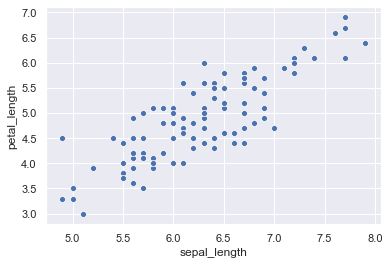

In [3]:
# 散布図の作成
sns.scatterplot(df_ex['sepal_length'], df_ex['petal_length'])

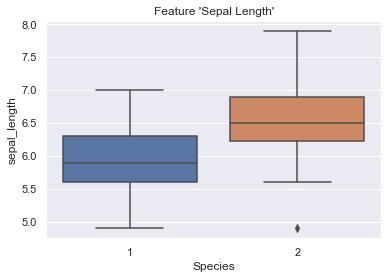

In [4]:
# 箱ひげ図の作成（Sepal Length）
plt.title('Feature \'Sepal Length\'')
sns.boxplot(x=df_ex['Species'], y=df_ex['sepal_length'] )

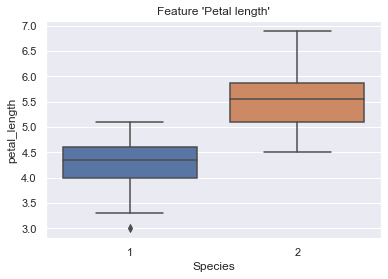

In [5]:
# 箱ひげ図の作成（Petal　Length）
plt.title('Feature \'Petal length\'')
sns.boxplot(x=df_ex['Species'], y=df_ex['petal_length'] )

Text(0.5, 1.0, "Feature 'Sepal Length'")

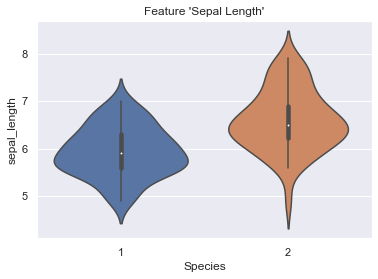

In [6]:
# sepal_length の特徴量の分布
sns.violinplot(x=df_ex['Species'], y=df_ex['sepal_length'])\
                                    .set_title('Feature \'Sepal Length\'')

Text(0.5, 1.0, "Feature 'Petal Length'")

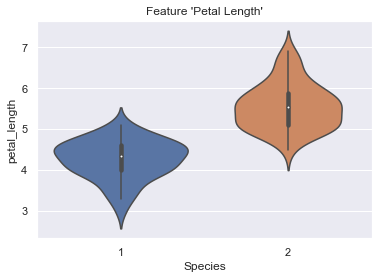

In [7]:
# petal_length の特徴量の分布
plt.title('Feature \'Petal Length\'')
sns.violinplot( x=df_ex['Species'], y=df_ex['petal_length'] )\
                                    .set_title('Feature \'Petal Length\'')

## 【問題3】前処理・訓練データと検証データの分割  
>前処理の一貫として、訓練データと検証データの分割を行います。今回は訓練データ75%、検証データ25%として分割してください。
>
>scikit-learnのtrain_test_splitが利用できます。公式ドキュメントのExamplesを参考に動かしてください。
>
>sklearn.model_selection.train_test_split — scikit-learn 0.21.3 documentation
>
>《注意点》
>
>データの分析まではPandasのDataFrameを使用してきました。しかし、scikit-learnはNumPyのndarrayを想定して作られています。そのため、この段階でndarrayへの変換を行いましょう。特徴量（説明変数）をX、正解（目的変数）をyというndarrayに格納します。
>
>《分割する理由》
>
>分類問題の目的は未知のデータを正しく分類することです。その目的が達成できているかを確認するため、実際には答えの分かっているデータの一部を学習には使わず残しておきます。この学習に使用していないデータで推定を行い、そこから求めた指標値によって検証します。学習に使うデータを訓練データ、検証に使うデータが検証データで、一般的に7対3から8対2程度の割合にします。

In [8]:
# 特徴量（説明変数）をX、正解（目的変数）をyというndarrayに格納

X = np.array(df_ex[['sepal_length','petal_length']])
y = np.array(df_ex['Species'])

#表示行数を１０行に設定
np.set_printoptions(threshold=10)
print(X)

#表示行数を無限大に設定
np.set_printoptions(threshold=np.inf)
print(y)

[[7.  4.7]
 [6.4 4.5]
 [6.9 4.9]
 ...
 [6.5 5.2]
 [6.2 5.4]
 [5.9 5.1]]
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]


In [9]:
from sklearn.model_selection import train_test_split

# 学習データとテストデータを７５：２５で分割
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)


(75, 2)
(75,)
(25, 2)
(25,)


## 【問題4】前処理・標準化  

>分類精度をあげるための加工を行います。手法ごとに適切な方法は異なりますが、ここでは一例として 標準化 を行うことにします。
>標準化を行うライブラリもscikit-learnに用意されています。これを使って標準化してください。
>
>sklearn.model_selection.train_test_split — scikit-learn 0.21.3 documentation
>
>《注意点》
>
>標準化は訓練用のデータでfitを行い、訓練用、検証用双方のデータにtransformを行います。検証データは学習の段階には存在しない未知のデータの代わりなので、標準化のための平均や標準偏差の計算に使ってはいけません。また、今回は分類問題なので、ラベルについては標準化させる必要はありません。
>
>《実際の問題での前処理は？》
>
>アヤメのデータセットのように綺麗で扱いやすい状況で提供されることはまずありません。分析を行いながら、様々な加工が必要になってきます。例えばWeek3の課題2で行った欠損値の確認の後、場合により欠損値の補間も行います。外れ値の確認や、複数のデータセットの整理などもあります。

In [10]:
from sklearn.preprocessing import StandardScaler

# 標準化クラスをインスタンス化
scaler = StandardScaler()

# 配列Xの平均と分散を計算して記憶する
scaler.fit(X_train)

# 標準化
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

#表示行数を１０行に設定
np.set_printoptions(threshold=10)

print(X_train_scaled)
print(X_test_scaled)


[[-1.77029021 -2.29778941]
 [ 0.03817879 -0.24187257]
 [-0.56464421  0.24187257]
 ...
 [-0.71534996  0.24187257]
 [-0.11252696 -0.72561771]
 [-1.01676146 -0.84655399]]
[[ 7.91707539e-01 -1.20936285e-01]
 [ 3.81787899e-02  8.46553995e-01]
 [ 9.42413289e-01  2.14825997e-15]
 ...
 [-1.16746721e+00 -1.08842656e+00]
 [-1.01676146e+00  2.14825997e-15]
 [-8.66055709e-01 -8.46553995e-01]]


## 【問題5】学習と推定  
>最近傍法（k-nearest neighbors, k-nn）で学習を行います。scikit-learnの公式ドキュメントのExamplesを参考に、k-nnの学習を行ってください。ここで入力するのは訓練データです。
>
>sklearn.neighbors.KNeighborsClassifier — scikit-learn 0.21.3 documentation
>
>学習が終わった後、検証データをpredictメソッドに入力し、推定を行ってください。
>
>パラメータが複数ありますが、今はそれらの理解を重視しません。最も基本的な要素として、n_neighborsの数があるため、これは複数試してみましょう。デフォルトの5、および1と3を最低限行ってください。5の場合を5-nn、3の場合を3-nnのように呼びます。

In [11]:
# 最近傍法で学習させる
from sklearn.neighbors import KNeighborsClassifier

#表示行数を無限大に設定
np.set_printoptions(threshold=np.inf)

# 近傍点を５に設定して学習
neigh = KNeighborsClassifier(n_neighbors=5)# インスタンス化
neigh.fit(X_train_scaled, y_train)# 学習
y_pred = neigh.predict(X_test_scaled)# 予測
print("近傍点'5'のときの予測\n{}".format(y_pred))

# 近傍点を１に設定して学習
neigh = KNeighborsClassifier(n_neighbors=1)# インスタンス化
neigh.fit(X_train_scaled, y_train)# 学習
y_pred_1 = neigh.predict(X_test_scaled)# 予測
print("近傍点'1'のときの予測\n{}".format(y_pred_1))

# 近傍点を３に設定して学習
neigh = KNeighborsClassifier(n_neighbors=3)# インスタンス化
neigh.fit(X_train_scaled, y_train)# 学習
y_pred_3 = neigh.predict(X_test_scaled)# 予測
print("近傍点'3'のときの予測\n{}".format(y_pred_3))


近傍点'5'のときの予測
[1 2 1 2 2 2 1 2 2 2 2 2 2 2 1 1 2 1 2 1 1 2 1 2 1]
近傍点'1'のときの予測
[1 2 2 2 2 2 1 2 2 1 2 2 2 1 1 1 2 1 2 1 1 2 1 2 1]
近傍点'3'のときの予測
[1 2 1 2 2 2 1 2 2 2 2 2 2 1 1 1 2 1 2 1 1 2 1 2 1]


## 【問題6】評価  
>
>検証データの特徴量を入力して得られた推定値と、検証データの正解値の近さを計算し、学習したモデルを評価します。
>
>2値分類を評価するための指標値には Accuracy（正解率）、Precision（適合率）、Recall（再現率）、F値 があります。それぞれの意味を理解するには、 混同行列（confusion matrix） を見ることになります。
>
>- scikit-learnを使い4種類の指標を計算する
>- 混同行列をscikit-learnを使い表示する
>- 4種類の指標値の意味について簡単に調査して文章でまとめる


In [12]:
#Accuracy（正解率）
from sklearn.metrics import accuracy_score
print("近傍点'5'のときの正解率： {}".format(accuracy_score(y_test, y_pred)))
print("近傍点'1'のときの正解率： {}".format(accuracy_score(y_test, y_pred_1)))
print("近傍点'3'のときの正解率： {}".format(accuracy_score(y_test, y_pred_3)))
print()

#Precision（適合率）
from sklearn.metrics import precision_score
print("近傍点'5'のときの適合率： {}".format(precision_score(y_test, y_pred)))
print("近傍点'1'のときの適合率： {}".format(precision_score(y_test, y_pred_1)))
print("近傍点'3'のときの適合率： {}".format(precision_score(y_test, y_pred_3)))
print()

#Recall（再現率）
from sklearn.metrics import recall_score
print("近傍点'5'のときの再現率： {}".format(recall_score(y_test, y_pred)))
print("近傍点'1'のときの再現率： {}".format(recall_score(y_test, y_pred_1)))
print("近傍点'3'のときの再現率： {}".format(recall_score(y_test, y_pred_3)))
print()

#F値
from sklearn.metrics import f1_score
print("近傍点'5'のときのF値： {}".format(f1_score(y_test, y_pred)))
print("近傍点'1'のときのF値： {}".format(f1_score(y_test, y_pred_1)))
print("近傍点'3'のときのF値： {}".format(f1_score(y_test, y_pred_3)))

近傍点'5'のときの正解率： 0.88
近傍点'1'のときの正解率： 0.84
近傍点'3'のときの正解率： 0.92

近傍点'5'のときの適合率： 1.0
近傍点'1'のときの適合率： 0.9090909090909091
近傍点'3'のときの適合率： 1.0

近傍点'5'のときの再現率： 0.7692307692307693
近傍点'1'のときの再現率： 0.7692307692307693
近傍点'3'のときの再現率： 0.8461538461538461

近傍点'5'のときのF値： 0.8695652173913044
近傍点'1'のときのF値： 0.8333333333333333
近傍点'3'のときのF値： 0.9166666666666666


In [13]:
# 混同行列をscikit-learnを使って表示する
from sklearn.metrics import confusion_matrix

#二項分類では、真陽性はC0,0、偽陽性は C1,０、偽陰性は C0,1、真陰性はC1,１。
print("近傍点'5'のときの混同行列：\n{}".format(confusion_matrix(y_test, y_pred)))
print("近傍点'1'のときの混同行列：\n{}".format(confusion_matrix(y_test, y_pred_1)))
print("近傍点'3'のときの混同行列：\n{}".format(confusion_matrix(y_test, y_pred_3)))


近傍点'5'のときの混同行列：
[[10  3]
 [ 0 12]]
近傍点'1'のときの混同行列：
[[10  3]
 [ 1 11]]
近傍点'3'のときの混同行列：
[[11  2]
 [ 0 12]]


## 【問題7】可視化  
>評価の一貫として可視化を行います。今回の場合2次元の特徴量で分類を行いましたから、散布図で可視化が可能です。以下にどう分割するかという 決定領域 を描く関数を用意しました。これを利用して可視化を行ってください。Xとyには訓練データまたは検証データを与えます。



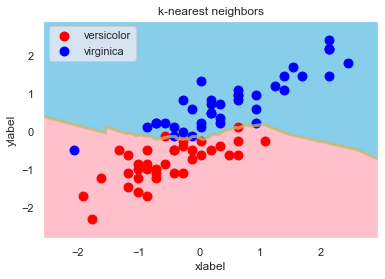

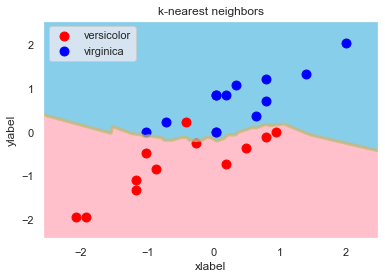

In [14]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches
def decision_region(X, y, model, step=0.01, title='decision region', xlabel='xlabel', ylabel='ylabel', target_names=['versicolor', 'virginica']):
    """
    2値分類を2次元の特徴量で学習したモデルの決定領域を描く。
    背景の色が学習したモデルによる推定値から描画される。
    散布図の点は訓練データまたは検証データである。

    Parameters
    ----------------
    X : ndarray, shape(n_samples, 2)
        特徴量
    y : ndarray, shape(n_samples,)
        ラベル
    model : object
        学習したモデルのインスンタスを入れる
    step : float, (default : 0.1)
        推定値を計算する間隔を設定する
    title : str
        グラフのタイトルの文章を与える
    xlabel, ylabel : str
        軸ラベルの文章を与える
    target_names= : list of str
        凡例の一覧を与える
    """
    # setting
    scatter_color = ['red', 'blue']
    contourf_color = ['pink', 'skyblue']
    n_class = 2
    # pred
    mesh_f0, mesh_f1  = np.meshgrid(np.arange(np.min(X[:,0])-0.5, np.max(X[:,0])+0.5, step), np.arange(np.min(X[:,1])-0.5, np.max(X[:,1])+0.5, step))
    mesh = np.c_[np.ravel(mesh_f0),np.ravel(mesh_f1)]
    y_pred = model.predict(mesh).reshape(mesh_f0.shape)
    # plot
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.contourf(mesh_f0, mesh_f1, y_pred, n_class-1, cmap=ListedColormap(contourf_color))
    plt.contour(mesh_f0, mesh_f1, y_pred, n_class-1, colors='y', linewidths=3, alpha=0.5)
    for i, target in enumerate(set(y)):
        plt.scatter(X[y==target][:, 0], X[y==target][:, 1], s=80, color=scatter_color[i], label=target_names[i], marker='o')
    patches = [mpatches.Patch(color=scatter_color[i], label=target_names[i]) for i in range(n_class)]
    plt.legend(handles=patches)
    plt.legend()
    plt.show()

# Xとyには訓練データまたは検証データを与えます。
decision_region(X_train_scaled, y_train, neigh, title='k-nearest neighbors')
decision_region(X_test_scaled, y_test, neigh, title='k-nearest neighbors',)



## 【問題8】他の手法の学習  
>以下の全ての手法について学習・推定・評価・可視化を行ってください。そして、指標値を１つの表にまとめてください。その表と決定領域を利用して結果を簡単に考察してください。どの手法がどの指標値で良かったかや、どういった決定領域になっていたかを述べてください。
>
>- 最近傍法
>- ロジスティック回帰
>- SVM
>- 決定木
>- ランダムフォレスト
>
>公式ドキュメントへのリンクは以下です。それぞれ調整すべき引数（ハイパーパラメータ）がありますが、この課題では扱いません。まずはデフォルトの値で実行してください。

In [15]:
# 精度の一覧表用の空のリストを用意
verification_result = []


#最近傍法

# 精度をまとめるための空のリストを用意
verification_neigh = ['k-nearest neighbors']

neigh = KNeighborsClassifier(n_neighbors=5)
neigh.fit(X_train_scaled, y_train)
y_pred_n = neigh.predict(X_test_scaled)
print("最近傍法による予測値\n{}".format(y_pred_n))

#Accuracy（正解率）
verification_neigh.append(accuracy_score(y_test, y_pred_n))

#Precision（適合率）
verification_neigh.append(precision_score(y_test, y_pred_n))

#Recall（再現率）
verification_neigh.append(recall_score(y_test, y_pred_n))

#F値
verification_neigh.append(f1_score(y_test, y_pred_n))



#ロジスティック回帰

# 精度をまとめるための空のリストを用意
verification_logistic = ['LogisticRegression']

from sklearn.linear_model import LogisticRegression

logistic = LogisticRegression(random_state=0)
logistic.fit(X_train_scaled, y_train)
y_pred_l = logistic.predict(X_test_scaled)
print("ロジスティック回帰による予測値\n{}".format(y_pred_l))

#Accuracy（正解率）
verification_logistic.append(accuracy_score(y_test, y_pred_l))

#Precision（適合率）
verification_logistic.append(precision_score(y_test, y_pred_l))

#Recall（再現率）
verification_logistic.append(recall_score(y_test, y_pred_l))

#F値
verification_logistic.append(f1_score(y_test, y_pred_l))




#SVM

# 精度をまとめるための空のリストを用意
verification_svm = ['SVM']

from sklearn.pipeline import make_pipeline
from sklearn.svm import SVC

svm = make_pipeline(StandardScaler(), SVC(gamma='auto'))# インスタンス化
svm.fit(X_train_scaled, y_train)
y_pred_s = svm.predict(X_test_scaled)
print("SVMによる予測値\n{}".format(y_pred_s))

#Accuracy（正解率）
verification_svm.append(accuracy_score(y_test, y_pred_s))

#Precision（適合率）
verification_svm.append(precision_score(y_test, y_pred_s))

#Recall（再現率）
verification_svm.append(recall_score(y_test, y_pred_s))

#F値
verification_svm.append(f1_score(y_test, y_pred_s))




#決定木

# 精度をまとめるための空のリストを用意
verification_tree = ['DecisionTree']

from sklearn.tree import DecisionTreeClassifier

tree = DecisionTreeClassifier(random_state=0)# インスタンス化
tree.fit(X_train_scaled, y_train)
y_pred_t = tree.predict(X_test_scaled)
print("決定木による予測値\n{}".format(y_pred_t))

#Accuracy（正解率）
verification_tree.append(accuracy_score(y_test, y_pred_t))

#Precision（適合率）
verification_tree.append(precision_score(y_test, y_pred_t))

#Recall（再現率）
verification_tree.append(recall_score(y_test, y_pred_t))

#F値
verification_tree.append(f1_score(y_test, y_pred_t))






#ランダムフォレスト
verification_forest = ['RandomForest']

from sklearn.ensemble import RandomForestClassifier
forest = RandomForestClassifier(max_depth=2, random_state=0)# インスタンス化
forest.fit(X_train_scaled, y_train)
y_pred_f = forest.predict(X_test_scaled)
print("ランダムフォレストによる予測値\n{}".format(y_pred_f))


#Accuracy（正解率）
verification_forest.append(accuracy_score(y_test, y_pred_f))

#Precision（適合率）
verification_forest.append(precision_score(y_test, y_pred_f))

#Recall（再現率）
verification_forest.append(recall_score(y_test, y_pred_f))

#F値
verification_forest.append(f1_score(y_test, y_pred_f))


# 表を作成するために計算結果を２次元配列にする
verification_result = [
            verification_neigh, 
            verification_logistic, 
            verification_svm, 
            verification_tree, 
            verification_forest
        ]

# 行と列のインデックスようのリストを用意
data_columns=['Model', 'Accuracy（正解率）', 'Precision（適合率）', 'Recall（再現率）', 'F値' ]

# pandas のデータフレームにする
df_verification = pd.DataFrame(data=verification_result, columns=data_columns)

display(df_verification)



最近傍法による予測値
[1 2 1 2 2 2 1 2 2 2 2 2 2 2 1 1 2 1 2 1 1 2 1 2 1]
ロジスティック回帰による予測値
[1 2 1 2 2 2 1 2 2 2 2 2 2 1 1 1 2 1 2 1 1 2 1 2 1]
SVMによる予測値
[1 2 1 2 2 2 1 2 2 2 2 2 2 1 1 1 2 1 2 1 1 2 1 2 1]
決定木による予測値
[1 2 1 2 2 2 1 2 2 2 2 2 2 1 2 1 2 1 2 1 1 2 1 2 1]
ランダムフォレストによる予測値
[2 2 2 2 2 2 1 2 2 2 2 2 2 1 1 1 2 1 2 1 1 2 1 2 1]


,Model,Accuracy（正解率）,Precision（適合率）,Recall（再現率）,F値
0,k-nearest neighbors,0.88,1.0,0.769231,0.869565
1,LogisticRegression,0.92,1.0,0.846154,0.916667
2,SVM,0.92,1.0,0.846154,0.916667
3,DecisionTree,0.88,1.0,0.769231,0.869565
4,RandomForest,0.84,1.0,0.692308,0.818182


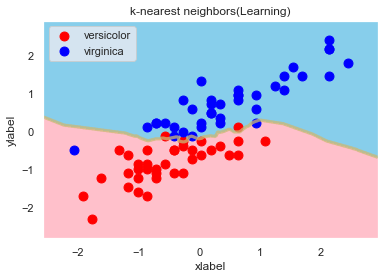

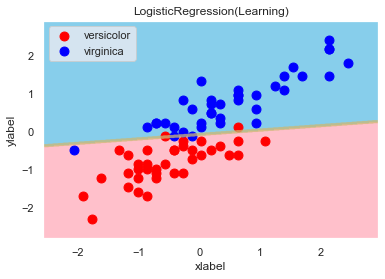

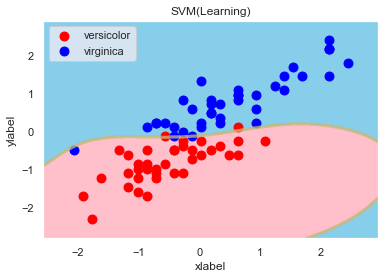

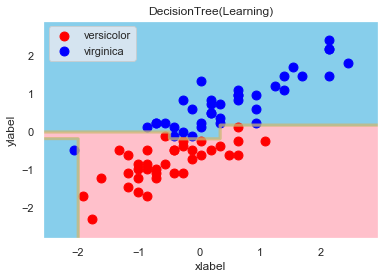

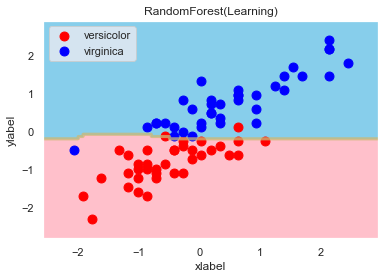

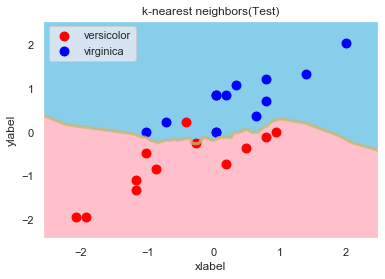

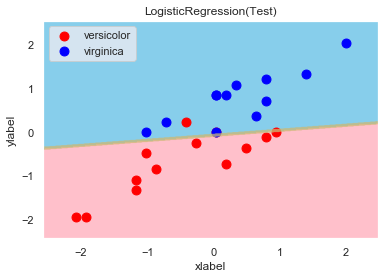

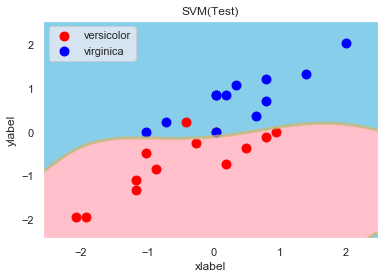

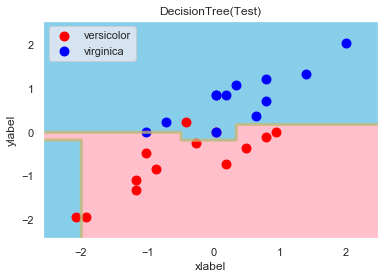

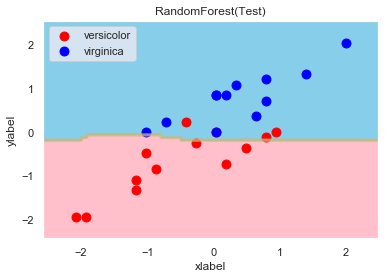

In [16]:


#可視化(学習データ)
decision_region(X_train_scaled, y_train, neigh, title='k-nearest neighbors(Learning)')
decision_region(X_train_scaled, y_train, logistic, title='LogisticRegression(Learning)')
decision_region(X_train_scaled, y_train, svm, title='SVM(Learning)')
decision_region(X_train_scaled, y_train, tree, title='DecisionTree(Learning)')
decision_region(X_train_scaled, y_train, forest, title='RandomForest(Learning)')


#可視化(テストデータ)
decision_region(X_test_scaled, y_test, neigh, title='k-nearest neighbors(Test)')
decision_region(X_test_scaled, y_test, logistic, title='LogisticRegression(Test)')
decision_region(X_test_scaled, y_test, svm, title='SVM(Test)')
decision_region(X_test_scaled, y_test, tree, title='DecisionTree(Test)')
decision_region(X_test_scaled, y_test, forest, title='RandomForest(Test)')


５つの手法を試した結果、適合率を除いて手法によって精度に差が出ることがわかった。  
特に、ロジスティック回帰とSVMは全体的に精度が高く、正解率とF値において 
90%を超えていた。一方ランダムフォレストは精度が低く、再現率では６０％台であった。  
それぞれの手法の特徴は以下の通り。  
 
- 最近傍法  
    - 中間レベルの精度であった。決定木と精度が同じであった。
- ロジスティック回帰  
    - SVMと並んですべての指標において精度が高かった。
- SVM  
    - SVMと並んですべての指標において精度が高かった。
- 決定木  
    - 最近傍法と同様に中間レベルの精度であった。
- ランダムフォレスト  
    - どの指標についても最も低く、精度が低い手法ではないかと思われる。

また、可視化してみたところ、手法によって境界線の引かれ方に違いがあることがわかった。  
それぞれの手法の境界線の特徴は以下の通り。  

- 最近傍法  
    - きめ細やかな曲線で描かれる。
- ロジスティック回帰  
    - 直線で描かれる。
- SVM  
    - 楕円形に近いようなカーブを描く。
- 決定木  
    - 四角い領域で区切って行ったような境界線になる。
- ランダムフォレスト  
    - 直線が連続したようなかなり粗い曲線で描かれる。


## 【問題9】（アドバンス課題）標準化の有無の比較  
>前処理として標準化を行いましたが、これを行わなかった場合どのような結果が得られるでしょうか。各手法に対しての指標値の表と決定領域の図を作成し比較および考察を行ってください。考察には標準化が機械学習の前処理としてどのような意味があるかを絡めてください。


In [17]:
# 精度の一覧表用の空のリストを用意
verification_result = []


#最近傍法
verification_neigh = ['k-nearest neighbors']

neigh = KNeighborsClassifier(n_neighbors=5)
neigh.fit(X_train, y_train)
y_pred_n = neigh.predict(X_test)
print("最近傍法による予測値（標準化なし）\n{}".format(y_pred_n))

#Accuracy（正解率）
verification_neigh.append(accuracy_score(y_test, y_pred_n))

#Precision（適合率）
verification_neigh.append(precision_score(y_test, y_pred_n))

#Recall（再現率）
verification_neigh.append(recall_score(y_test, y_pred_n))

#F値
verification_neigh.append(f1_score(y_test, y_pred_n))



#ロジスティック回帰
verification_logistic = ['LogisticRegression']

from sklearn.linear_model import LogisticRegression
logistic = LogisticRegression(random_state=0)
logistic.fit(X_train, y_train)
y_pred_l = logistic.predict(X_test)
print("ロジスティック回帰による予測値（標準化なし）\n{}".format(y_pred_l))

#Accuracy（正解率）
verification_logistic.append(accuracy_score(y_test, y_pred_l))

#Precision（適合率）
verification_logistic.append(precision_score(y_test, y_pred_l))

#Recall（再現率）
verification_logistic.append(recall_score(y_test, y_pred_l))

#F値
verification_logistic.append(f1_score(y_test, y_pred_l))




#SVM
verification_svm = ['SVM']

from sklearn.pipeline import make_pipeline
from sklearn.svm import SVC
svm = make_pipeline(StandardScaler(), SVC(gamma='auto'))
svm.fit(X_train, y_train)
y_pred_s = svm.predict(X_test)
print("SVMによる予測値（標準化なし）\n{}".format(y_pred_s))

#Accuracy（正解率）
verification_svm.append(accuracy_score(y_test, y_pred_s))

#Precision（適合率）
verification_svm.append(precision_score(y_test, y_pred_s))

#Recall（再現率）
verification_svm.append(recall_score(y_test, y_pred_s))

#F値
verification_svm.append(f1_score(y_test, y_pred_s))




#決定木
verification_tree = ['DecisionTree']

from sklearn.tree import DecisionTreeClassifier
tree = DecisionTreeClassifier(random_state=0)
tree.fit(X_train, y_train)
y_pred_t = tree.predict(X_test)
print("決定木による予測値（標準化なし）\n{}".format(y_pred_t))

#Accuracy（正解率）
verification_tree.append(accuracy_score(y_test, y_pred_t))

#Precision（適合率）
verification_tree.append(precision_score(y_test, y_pred_t))

#Recall（再現率）
verification_tree.append(recall_score(y_test, y_pred_t))

#F値
verification_tree.append(f1_score(y_test, y_pred_t))




#ランダムフォレスト
verification_forest = ['RandomForest']

from sklearn.ensemble import RandomForestClassifier
forest = RandomForestClassifier(max_depth=2, random_state=0)#
forest.fit(X_train, y_train)
y_pred_f = forest.predict(X_test)
print("ランダムフォレストによる予測値（標準化なし）\n{}".format(y_pred_f))


#Accuracy（正解率）
verification_forest.append(accuracy_score(y_test, y_pred_f))

#Precision（適合率）
verification_forest.append(precision_score(y_test, y_pred_f))

#Recall（再現率）
verification_forest.append(recall_score(y_test, y_pred_f))

#F値
verification_forest.append(f1_score(y_test, y_pred_f))



# 表を作成するために計算結果を２次元配列にする
verification_result = [
            verification_neigh, 
            verification_logistic, 
            verification_svm, 
            verification_tree, 
            verification_forest
        ]

# 行と列のインデックスようのリストを用意
data_columns=['Model', 'Accuracy（正解率）', 'Precision（適合率）', 'Recall（再現率）', 'F値' ]

# pandas のデータフレームにする
df_verification = pd.DataFrame(data=verification_result, columns=data_columns)
display(df_verification)



最近傍法による予測値（標準化なし）
[1 2 1 2 2 2 1 2 2 2 2 2 2 1 1 1 2 1 2 1 1 2 1 2 1]
ロジスティック回帰による予測値（標準化なし）
[1 2 2 2 2 2 1 2 2 2 2 2 2 1 1 1 2 1 2 1 1 2 1 2 1]
SVMによる予測値（標準化なし）
[1 2 1 2 2 2 1 2 2 2 2 2 2 1 1 1 2 1 2 1 1 2 1 2 1]
決定木による予測値（標準化なし）
[1 2 1 2 2 2 1 2 2 2 2 2 2 1 2 1 2 1 2 1 1 2 1 1 1]
ランダムフォレストによる予測値（標準化なし）
[2 2 2 2 2 2 1 2 2 2 2 2 2 1 1 1 2 1 2 1 1 2 1 2 1]


,Model,Accuracy（正解率）,Precision（適合率）,Recall（再現率）,F値
0,k-nearest neighbors,0.92,1.000000,0.846154,0.916667
1,LogisticRegression,0.88,1.000000,0.769231,0.869565
2,SVM,0.92,1.000000,0.846154,0.916667
3,DecisionTree,0.84,0.909091,0.769231,0.833333
4,RandomForest,0.84,1.000000,0.692308,0.818182


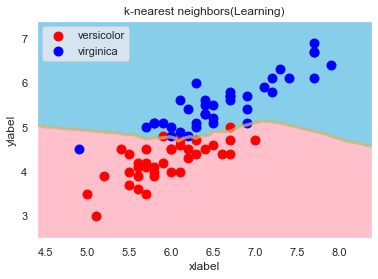

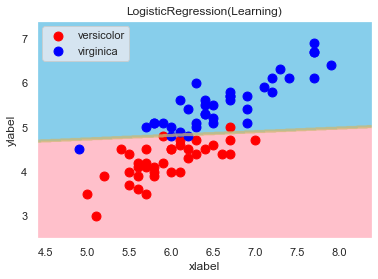

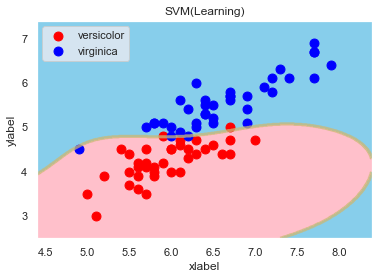

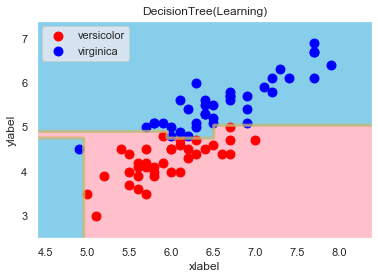

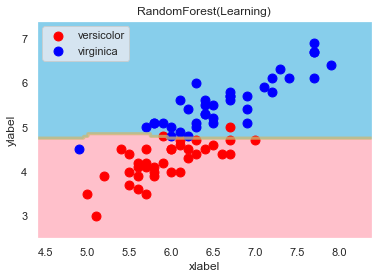

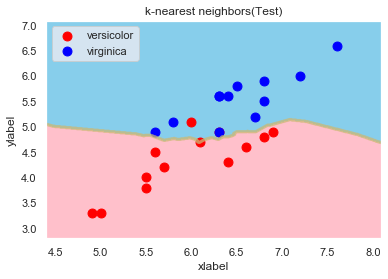

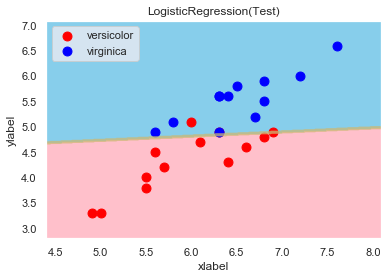

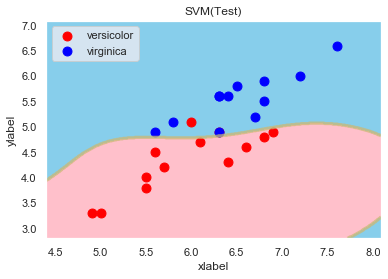

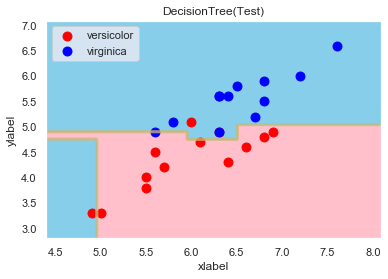

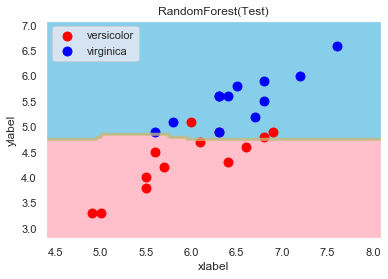

In [18]:


#可視化(学習データ)
decision_region(X_train, y_train, neigh, title='k-nearest neighbors(Learning)')
decision_region(X_train, y_train, logistic, title='LogisticRegression(Learning)')
decision_region(X_train, y_train, svm, title='SVM(Learning)')
decision_region(X_train, y_train, tree, title='DecisionTree(Learning)')
decision_region(X_train, y_train, forest, title='RandomForest(Learning)')


#可視化(テストデータ)
decision_region(X_test, y_test, neigh, title='k-nearest neighbors(Test)')
decision_region(X_test, y_test, logistic, title='LogisticRegression(Test)')
decision_region(X_test, y_test, svm, title='SVM(Test)')
decision_region(X_test, y_test, tree, title='DecisionTree(Test)')
decision_region(X_test, y_test, forest, title='RandomForest(Test)')


作成した表を見比べるとロジスティック回帰と決定木は標準化したデータの方が  
全体的に精度が高くなった。  
一方、最近傍法については全体的に標準化前の方が精度が高かった。  
SVMとランダムフォレストについては結果は変わらなかった。  
標準化が適した手法と適さない手法があると思われ、ロジスティック回帰と決定木は  
適しているといえる。  
また、可視化した図を見ても同様のことが言える。例えばロジスティック回帰を見ると  
標準化していない学習データでは左下の外れたVirginicaを捉え切れていないが、  
標準化したデータではうまく捉えている。一方、標準化によって精度が下がった最近傍法  
のテストデータの図を比較すると、境界線がきめ細かくなったせいで、  
学習用データに厳密に適用した箇所にたまたま別のアヤメのデータが入り込んで  
誤りになったために精度が下がったように思われる。  
標準化することで、境界線が学習データの実際の境界に近づきやすいが、  
手法によってはかえってそれが仇になって精度が下がることがあることがわかった。

## 【問題10】（アドバンス課題）全ての目的変数を使用して精度が高い手法  
>ここまではアヤメの種類を減らし2値分類を行ってきましたが、3種類全てを使った多値分類を行います。学習と推定、評価を行って、最も精度の高い手法を探してください。
>
>《多値になることでの変更点》
>
>指標値Precision（適合率）、Recall（再現率）、F値はライブラリのパラメータをデフォルトから変更する必要があります。マイクロ平均やマクロ平均という考え方を使います。
>
>決定領域を可視化する前述の関数は適切に書き換える必要があります。以下が出力例です。
>ロジスティック回帰やSVMは2値分類を基本とした手法で、多値分類には工夫が必要ですが、scikit-learnでは自動的に判断して処理が行われるため変更は必要ありません。

In [19]:
# 特徴量（説明変数）をX、正解（目的変数）をyというndarrayに格納
X_all = np.array(df[['sepal_length', 'petal_length']])
y_all = np.array(df['Species'])

# 学習用とテスト用に分割
X_train_all, X_test_all, y_train_all, y_test_all = train_test_split(X_all, y_all, test_size=0.25, random_state=0)

# 標準化
scaler = StandardScaler()
scaler.fit(X_train_all)
X_train_scaled_all = scaler.transform(X_train_all)
X_test_scaled_all = scaler.transform(X_test_all)


In [20]:
# 精度の一覧表用の空のリストを用意
verification_result = []


#最近傍法
verification_neigh = ['k-nearest neighbors']

neigh = KNeighborsClassifier(n_neighbors=5)
neigh.fit(X_train_scaled_all, y_train_all)
y_pred_n = neigh.predict(X_test_scaled_all)
print(y_pred_n)

#Accuracy（正解率）
verification_neigh.append(accuracy_score(y_test_all, y_pred_n))

#Precision（適合率）
verification_neigh.append(precision_score(y_test_all, y_pred_n, average='micro'))

#Recall（再現率）
verification_neigh.append(recall_score(y_test_all, y_pred_n, average='micro'))

#F値
verification_neigh.append(f1_score(y_test_all, y_pred_n, average='micro'))



#ロジスティック回帰
verification_logistic = ['LogisticRegression']

logistic = LogisticRegression(random_state=0)# インスタンス化
logistic.fit(X_train_scaled_all, y_train_all)
y_pred_l = logistic.predict(X_test_scaled_all)
print(y_pred_l)

#Accuracy（正解率）
verification_logistic.append(accuracy_score(y_test_all, y_pred_l))

#Precision（適合率）
verification_logistic.append(precision_score(y_test_all, y_pred_l, average='macro'))

#Recall（再現率）
verification_logistic.append(recall_score(y_test_all, y_pred_l, average='micro'))

#F値
verification_logistic.append(f1_score(y_test_all, y_pred_l, average='micro'))




#SVM
verification_svm = ['SVM']

svm = make_pipeline(StandardScaler(), SVC(gamma='auto'))# インスタンス化
svm.fit(X_train_scaled_all, y_train_all)
y_pred_s = svm.predict(X_test_scaled_all)
print(y_pred_s)

#Accuracy（正解率）
verification_svm.append(accuracy_score(y_test_all, y_pred_s))

#Precision（適合率）
verification_svm.append(precision_score(y_test_all, y_pred_s, average='micro'))

#Recall（再現率）
verification_svm.append(recall_score(y_test_all, y_pred_s, average='micro'))

#F値
verification_svm.append(f1_score(y_test_all, y_pred_s, average='micro'))




#決定木
verification_tree = ['DecisionTree']

tree = DecisionTreeClassifier(random_state=0)# インスタンス化
tree.fit(X_train_scaled_all, y_train_all)
y_pred_t = tree.predict(X_test_scaled_all)
print(y_pred_t)

#Accuracy（正解率）
verification_tree.append(accuracy_score(y_test_all, y_pred_t))

#Precision（適合率）
verification_tree.append(precision_score(y_test_all, y_pred_t, average='micro'))

#Recall（再現率）
verification_tree.append(recall_score(y_test_all, y_pred_t, average='micro'))

#F値
verification_tree.append(f1_score(y_test_all, y_pred_t, average='micro'))




#ランダムフォレスト
verification_forest = ['RandomForest']

forest = RandomForestClassifier(max_depth=2, random_state=0)# インスタンス化
forest.fit(X_train_scaled_all, y_train_all)
y_pred_f = forest.predict(X_test_scaled_all)
print(y_pred_f)


#Accuracy（正解率）
verification_forest.append(accuracy_score(y_test_all, y_pred_f))

#Precision（適合率）
verification_forest.append(precision_score(y_test_all, y_pred_f, average='micro'))

#Recall（再現率）
verification_forest.append(recall_score(y_test_all, y_pred_f, average='micro'))

#F値
verification_forest.append(f1_score(y_test_all, y_pred_f, average='micro'))



# 表を作成するために計算結果を２次元配列にする
verification_result = [
            verification_neigh, 
            verification_logistic, 
            verification_svm, 
            verification_tree, 
            verification_forest
        ]

# 行と列のインデックスようのリストを用意
data_columns=['Model', 'Accuracy（正解率）', 'Precision（適合率）', 'Recall（再現率）', 'F値' ]

# pandas のデータフレームにする
df_verification = pd.DataFrame(data=verification_result, columns=data_columns)
display(df_verification)



[2 1 0 2 0 2 0 1 1 1 2 1 1 1 1 0 1 1 0 0 2 1 0 0 1 0 0 1 1 0 2 1 0 2 2 1 0
 2]
[2 1 0 2 0 2 0 1 2 1 2 1 1 1 1 0 1 1 0 0 2 1 0 0 2 0 0 1 1 0 2 1 0 2 2 1 0
 2]
[2 1 0 2 0 2 0 1 1 1 2 1 1 1 1 0 1 1 0 0 2 1 0 0 1 0 0 1 1 0 2 1 0 2 2 1 0
 2]
[2 1 0 2 0 2 0 1 2 1 2 1 1 1 1 0 1 1 0 0 1 1 0 0 2 0 0 1 1 0 2 1 0 1 2 1 0
 2]
[2 1 0 2 0 2 0 1 1 1 2 1 1 1 1 0 1 1 0 0 1 1 0 0 1 0 0 1 1 0 2 1 0 1 2 1 0
 2]


,Model,Accuracy（正解率）,Precision（適合率）,Recall（再現率）,F値
0,k-nearest neighbors,0.947368,0.947368,0.947368,0.947368
1,LogisticRegression,0.947368,0.939394,0.947368,0.947368
2,SVM,0.947368,0.947368,0.947368,0.947368
3,DecisionTree,0.894737,0.894737,0.894737,0.894737
4,RandomForest,0.894737,0.894737,0.894737,0.894737


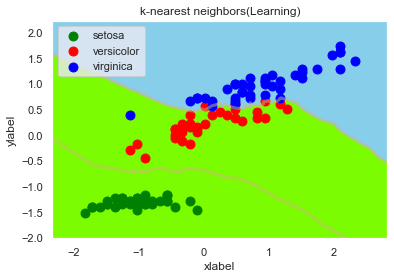

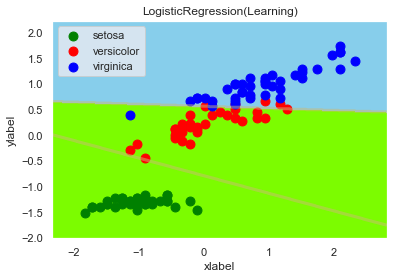

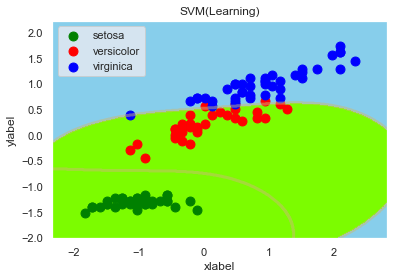

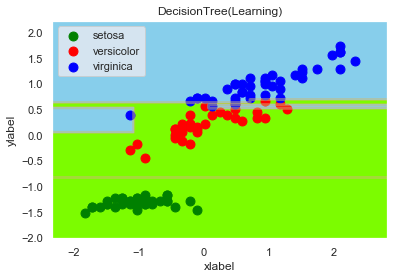

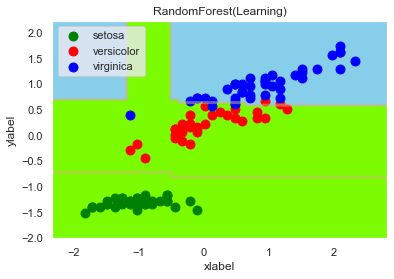

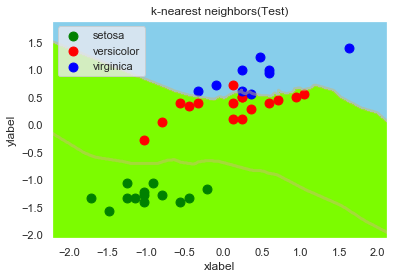

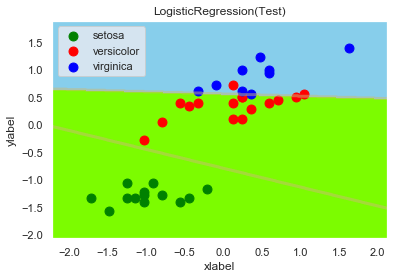

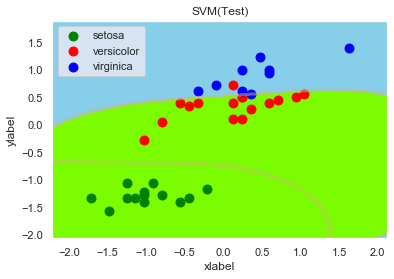

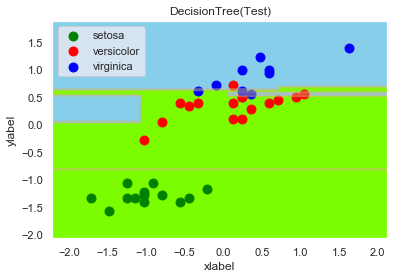

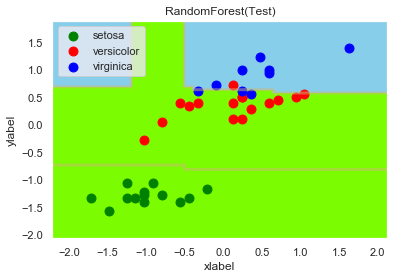

In [21]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches
def decision_region_3d(X, y, model, step=0.01, title='decision region', xlabel='xlabel', ylabel='ylabel', target_names=['setosa', 'versicolor', 'virginica']):
    """
    2値分類を2次元の特徴量で学習したモデルの決定領域を描く。
    背景の色が学習したモデルによる推定値から描画される。
    散布図の点は訓練データまたは検証データである。

    Parameters
    ----------------
    X : ndarray, shape(n_samples, 2)
        特徴量
    y : ndarray, shape(n_samples,)
        ラベル
    model : object
        学習したモデルのインスンタスを入れる
    step : float, (default : 0.1)
        推定値を計算する間隔を設定する
    title : str
        グラフのタイトルの文章を与える
    xlabel, ylabel : str
        軸ラベルの文章を与える
    target_names= : list of str
        凡例の一覧を与える
    """
    # setting
    scatter_color = [ 'Green', 'red', 'blue']
    contourf_color = ['lawngreen', 'pink', 'skyblue']
    n_class = 2
    # pred
    mesh_f0, mesh_f1  = np.meshgrid(np.arange(np.min(X[:,0])-0.5, np.max(X[:,0])+0.5, step), np.arange(np.min(X[:,1])-0.5, np.max(X[:,1])+0.5, step))
    #mesh_f0, mesh_f1,mesh_f2  = np.meshgrid(np.arange(np.min(X[:,0])-0.5, np.max(X[:,0])+0.5, step), 
    #                                                                np.arange(np.min(X[:,1])-0.5, np.max(X[:,1])+0.5, step),
    #                                                               np.arange(np.min(X[:,1])-0.5, np.max(X[:,1])+0.5, step))
    
    #me=len(np.ravel(mesh_f0))
    #mesh = np.empty((me, 0), dtype=int)
    #mesh = np.c_[mesh,np.ravel(mesh_f0)]
    #mesh = np.c_[mesh,np.ravel(mesh_f1)]
    #mesh = np.c_[mesh,np.ravel(mesh_f2)]
    
    mesh = np.c_[np.ravel(mesh_f0),np.ravel(mesh_f1)]
    #mesh = np.c_[np.ravel(mesh_f0),np.ravel(mesh_f1),np.ravel(mesh_f2)]
    #print(mesh.shape)
    #print(mesh_f0.shape)
    y_pred = model.predict(mesh).reshape(mesh_f0.shape)
    # plot
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.contourf(mesh_f0, mesh_f1, y_pred, n_class-1, cmap=ListedColormap(contourf_color))
    #plt.contourf(mesh_f0, mesh_f1, mesh_f2,y_pred, n_class-1, cmap=ListedColormap(contourf_color))
    plt.contour(mesh_f0, mesh_f1, y_pred, n_class-1, colors='y', linewidths=3, alpha=0.5)
    for i, target in enumerate(set(y)):
        plt.scatter(X[y==target][:, 0], X[y==target][:, 1], s=80, color=scatter_color[i], label=target_names[i], marker='o')
    patches = [mpatches.Patch(color=scatter_color[i], label=target_names[i]) for i in range(n_class)]
    plt.legend(handles=patches)
    plt.legend()
    plt.show()
# Xとyには訓練データまたは検証データを与えます。
#decision_region(X_train_scaled, y_train, neigh, title='k-nearest neighbors')
#decision_region(X_test_scaled, y_test, neigh, title='k-nearest neighbors',)

                                             

#可視化(学習データ)
decision_region_3d(X_train_scaled_all, y_train_all, neigh, title='k-nearest neighbors(Learning)')
decision_region_3d(X_train_scaled_all, y_train_all, logistic, title='LogisticRegression(Learning)')
decision_region_3d(X_train_scaled_all, y_train_all, svm, title='SVM(Learning)')
decision_region_3d(X_train_scaled_all, y_train_all, tree, title='DecisionTree(Learning)')
decision_region_3d(X_train_scaled_all, y_train_all, forest, title='RandomForest(Learning)')


#可視化(テストデータ)
decision_region_3d(X_test_scaled_all, y_test_all, neigh, title='k-nearest neighbors(Test)')
decision_region_3d(X_test_scaled_all, y_test_all, logistic, title='LogisticRegression(Test)')
decision_region_3d(X_test_scaled_all, y_test_all, svm, title='SVM(Test)')
decision_region_3d(X_test_scaled_all, y_test_all, tree, title='DecisionTree(Test)')
decision_region_3d(X_test_scaled_all, y_test_all, forest, title='RandomForest(Test)')



検証の結果、３種類のアヤメを分類させた場合、最近傍法とSVMが最も精度が高いことがわかった。

以上